In [1]:
include("../../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, Printf, LaTeXStrings

In [3]:
FILE_F_MAP = "../../test/datatest/F_REFERENCE.txt"
FILE_PS = "../../test/datatest/file_pk.txt"
FILE_BACKGROUND = "../../test/datatest/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)


I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../../test/datatest/file_pk.txt"
# F window function input file : "../../test/datatest/F_REFERENCE.txt"
# CLASS Background input file: "../../test/datatest/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1919383435064 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747017093795 Mpc/h_0
# 	 comoving z_eff = 0.15045635814042582 
# 	 Volume of the survey V_survey = 3.845366253274408e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [4]:
GaPSE.print_map_ξ_multipole(cosmo, "xi_doppler_L0.txt", "auto_doppler"; 
    use_windows = false, N_μs = 50, N_log=1000)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01



time needed for map_integral_on_mu for auto_doppler [in s] = 1.44463 


In [5]:
tab_pk = readdlm(FILE_PS, comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

In [6]:
my_table = readdlm("xi_doppler_L0.txt", comments=true)
my_ss = convert(Vector{Float64}, my_table[:, 1]);
my_dopplers = convert(Vector{Float64}, my_table[:, 2]);
mattia_table = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/Monopoles_without_window/xi_doppler_L0.txt")
mattia_ss = convert(Vector{Float64}, mattia_table[2:end, 1]);
mattia_dopplers = convert(Vector{Float64}, mattia_table[2:end, 2]);

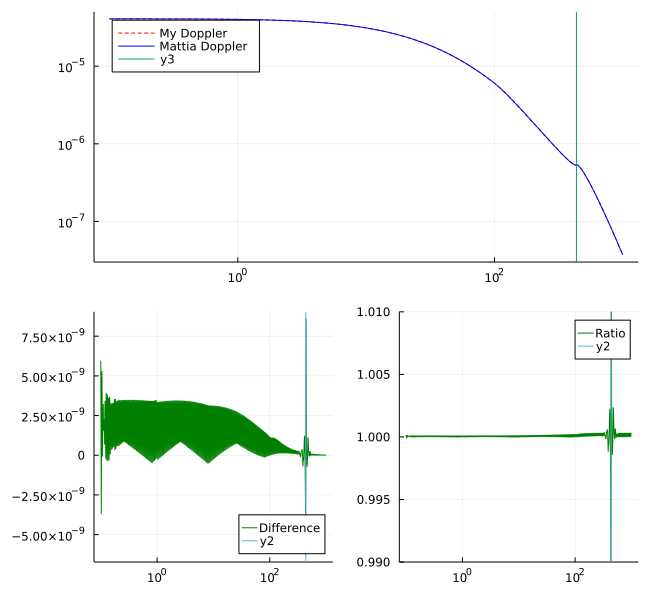

In [7]:
my_xs = my_ss
my_ys = my_dopplers
xs = mattia_ss
ys = mattia_dopplers
spline = Spline1D(xs, ys)

S_VLIM=cosmo.s_eff

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :solid], legend=:topleft)
vline!(p1, [S_VLIM])

p2 = plot(my_xs, spline.(my_xs) .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
vline!(p2, [S_VLIM])

p3 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
    ylim=(0.99,1.01))
vline!(p3, [S_VLIM])

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

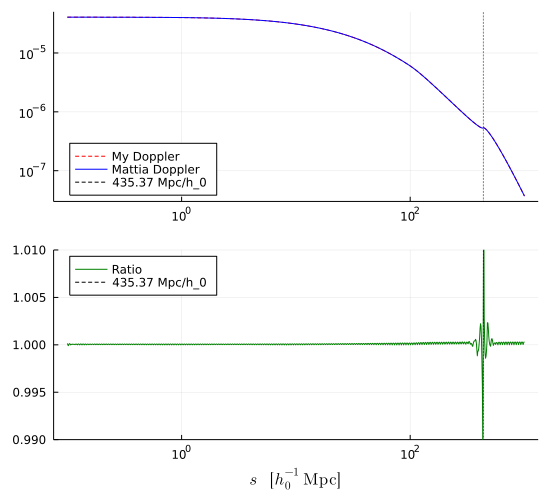

In [9]:
my_xs = my_ss
my_ys = my_dopplers
xs = mattia_ss
ys = mattia_dopplers
spline = Spline1D(xs, ys)

S_VLIM = cosmo.s_eff
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :solid], legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
    ylim=(0.99,1.01), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
savefig(P, "xi_AutoDoppler_L0.pdf")
display(P)